In [1]:
using WAV, FFTW, Plots

import DSP, DSP.Frequencies
using DSP.Windows

s, rate = wavread("test.wav")

([-0.0367138; -0.0629902; … ; 0.0013123; 0.0013123], 16000.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x80, 0x3e, 0x00, 0x00, 0x00, 0x7d, 0x00, 0x00, 0x02, 0x00, 0x10, 0x00])])

# STFT definition

We will use the already defined functions in `DSP`, adapting the `spectrogram` and `stft` functions.

First of all we define a container type for our stft.

In [2]:
const FloatRange{T} = StepRangeLen{T,Base.TwicePrecision{T},Base.TwicePrecision{T}}

struct STFT{T, F<:Union{Frequencies, AbstractRange}} 
    stft::Matrix{T}
    freq::F
    time::FloatRange{Float64}
    width::Int
#     window_norm::Float64
end

Libc.time(s::STFT) = s.time
freq(s::STFT) = s.freq
vals(s::STFT) = s.stft
# window_norm(s::STFT) = s.window_norm
width(s::STFT) = s.width

Base.eltype(m::STFT) = eltype(vals(m))
Base.size(m::STFT{T, Frequencies}, etc...) where T = size(vals(m), etc...)
Base.getindex(m::STFT{T, Frequencies}, etc...) where T = getindex(vals(m), etc...)

# Functions to recover informations about the stft from the 
# quantities we saved inside the type
fs(s::STFT) = round(Int, width(s)/(2*first(time(s))))
noverlap(s::STFT) = round(Int, width(s) - fs(s)*step(time(s)))
or_length(s::STFT) = (length(time(m))-1)*50 + width(m)


or_length (generic function with 1 method)

We can now define the stft function, which is just a wrapper around `DSP.stft`. 

This function turn out to be much faster than the one we defined in a previous try, by a factor of 1000.

In [3]:
function stft(s::AbstractVector{T}, n::Int=length(s)>>3, noverlap::Int=n>>1;
                    onesided::Bool=eltype(s)<:Real, nfft::Int=DSP.nextfastfft(n), 
                    fs::Real=1, window::Union{Function,AbstractVector,Nothing}=nothing) where T

    out = DSP.stft(s, n, noverlap; onesided=onesided, fs=fs, window=window)
    STFT(out, onesided ? DSP.rfftfreq(nfft, fs) : DSP.fftfreq(nfft, fs),
                (n/2 : n-noverlap : (size(out,2)-1)*(n-noverlap)+n/2) / fs, n)
#                 n, DSP.Periodograms.compute_window(window, n)[2])
end

stft (generic function with 3 methods)

Let us define a function to visualize the `STFT` type, and test it.

In [87]:
function show(s::STFT, pre = x->x) 
    T = map(x->round(x, digits = 2), range(first(time(m)), last(time(m)), length= 4))
    F = map(x->round(Int, x), range(first(freq(m)), last(freq(m)), length= 5))
    heatmap(pre.(abs.(vals(s))), xaxis = ("Time (s)"), yaxis = ("Frequencies (Hz)"),
        xticks = (range(1,size(m,2), length= 4), T),
        yticks = (range(1,size(m,1), length= 5), F))
end

show (generic function with 2 methods)

  0.000755 seconds (86 allocations: 917.625 KiB)


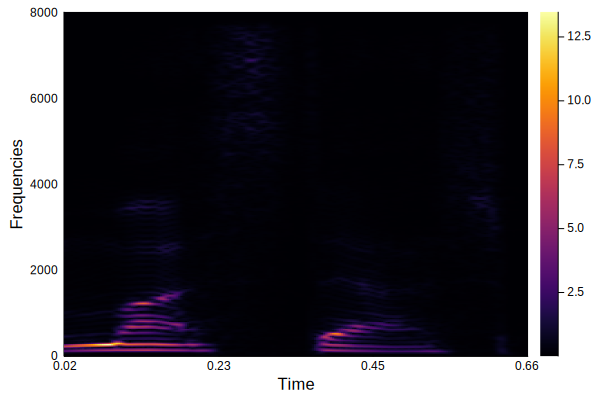

In [5]:
m = stft(s[1:end], 500, 450,  fs = rate, window = hanning)
@time m = stft(s[1:end], 500, 450,  fs = rate, window = hanning)
show(m)

We now need to define the inverse procedure. We start by definining a fast function to add vectors (inspired by `Compat.copyto!`)

In [6]:
function addto!(dest, dof, src, sof)
    @assert sof <= length(src) 
    @assert dof + length(src) - sof  <= length(dest)
    @inbounds for i in 0:(length(src) - sof)
        dest[i + dof] += src[i + sof]
    end
end

addto! (generic function with 1 method)

The inverse procedure is then quite simple.

In [99]:
function istft(m::STFT)
    onesided = all(freq(m) .>= 0)
    @assert onesided
    a = irfft(vals(m), width(m), 1)
    x = zeros(or_length(m))
    tmp = zeros(or_length(m))
    for i in 1:size(a,2)
        addto!(x, (i-1)*(width(m)-noverlap(m))+1, a[:,i], 1)
        addto!(tmp, (i-1)*(width(m)-noverlap(m))+1, ones(size(a,1)), 1)
    end
    x./=(tmp)/2
end

istft (generic function with 1 method)

Check to see if the reconstruction is good. I do not know why but we have a small problem at the beginning.

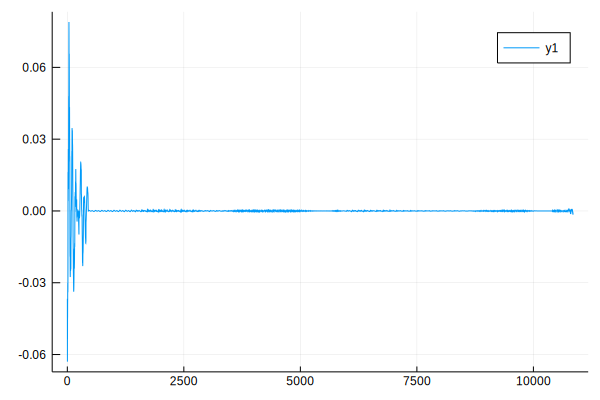

In [8]:
s2 = istft(stft(s[1:end], 500, 450, fs = rate, window = hanning))
plot(s[1:length(s2)]-s2)

Let us test these procedure on an artificial signal.

  0.001599 seconds (82 allocations: 1.648 MiB)


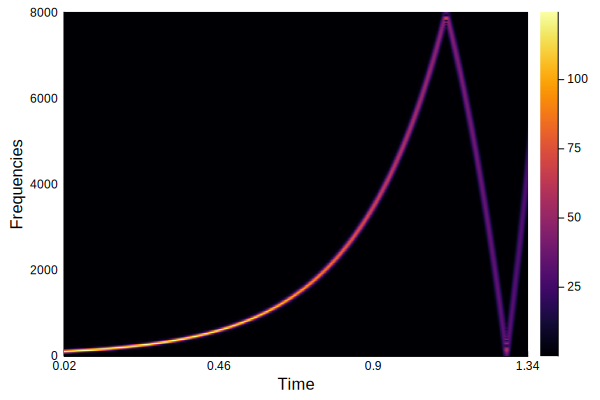

In [9]:
x = [sin(exp((t+20000)/4000)) for t in 1:2size(s,1) ]

@time m = stft(x, 500, 450, fs = rate, window = hanning)
show(m) 

# Lift procedure

We first build a type container for the lift.

In [10]:
struct Lift{T}
    lift::Array{T, 3}
    freq::Frequencies
    time::FloatRange{Float64}
    slopes::FloatRange{Float64}
    width::Int
end

Base.eltype(m::Lift{T}) where T = eltype(lift(m))
Base.size(m::Lift{T}, etc...) where T = size(lift(m), etc...)
Base.getindex(m::Lift{T}, etc...) where T = getindex(lift(m), etc...)

width(L::Lift) = L.width
freq(L::Lift) = L.freq
lift(L::Lift) = L.lift
Libc.time(L::Lift) = L.time
slopes(L::Lift) = L.slopes

slopes (generic function with 1 method)

We start by computing the slopes matrix

In [11]:
function gradient_uneven(F::Array{T,2},dx::Real ,dy::Real) where T<:Number
    gradx = (F - circshift(F,[1,0]))/dx
    grady = (circshift(F,[0,-1]) - circshift(F,[0,1]))/(2*dy)
    return gradx, grady
end

# Computation of the slopes for a given input matrix M
function slopes(M::Array{T, 2}, zs::FloatRange{Float64}, d_time ::Real, d_freq::Real;
                epsGrad = 1e-4, σ = (1., 1.)) where {T<:Real}
    # Recall that the xs correspond to frequencies and the ys to the time
    g_freq, g_time = gradient_uneven(M, d_freq, d_time) 
    gradNorm = g_freq.^2+g_time.^2
    
    # Generate the matrix of slopes
    N = length(zs)
    slopeMatrix = similar(M, Union{Int64,Nothing})
    for i=1:size(M,1),  j=1:size(M,2)
        if gradNorm[i,j] > epsGrad^2
            if first(zs) <= (-g_time[i,j]/g_freq[i,j]) <= last(zs)
                slopeMatrix[i,j] = round(Int,(-g_time[i,j]/g_freq[i,j])/rng(zs)*(N/2-1/2)+N/2+1/2)
            elseif (-g_time[i,j]/g_freq[i,j]) > last(zs)
                slopeMatrix[i,j] = N
            else
                slopeMatrix[i,j] = 1
            end
        else
            slopeMatrix[i,j] = nothing
        end
    end
    slopeMatrix
# 
#     imfilter(slopeMatrix,ImageFiltering.Kernel.gaussian((σ[1],σ[2]*dx/dy)))
end

slopes (generic function with 2 methods)

There is the problem, when computing the gradients since the range of the frequencies is humungous w.r.t. the time. To fix this, we compute it as if they where in the range [0,1].

In [26]:
rng(t::Union{FloatRange{T},Frequencies, Array{T,1}}) where T<: Real = last(t) - first(t)
normalize(x :: Union{Frequencies, FloatRange{T}}) where T = (first(x)/last(x)):(step(x)/last(x)):1

function zs(m::STFT; N::Int = 100, ratio::Real = 10) 
    f_norm = normalize(freq(m))
    ratio*range(-rng(f_norm)/rng(time(m)),rng(f_norm)/rng(time(m)), length = N)
end

slopes(m::STFT; args...) = slopes(abs.(vals(m)), zs(m; args...), step(time(m)), step(normalize(freq(m))))


slopes (generic function with 5 methods)

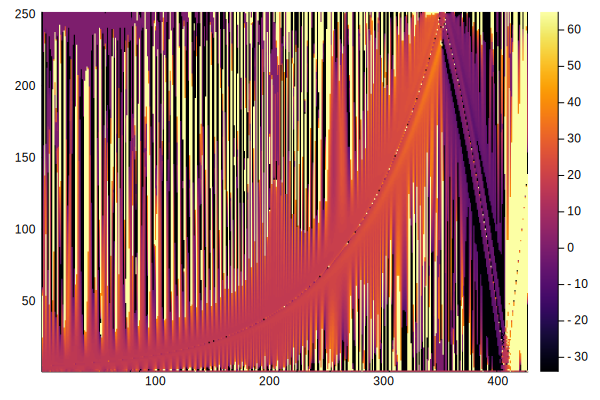

In [27]:
S, _ = slopes(m, 100, 10)
heatmap([S[i,j]==nothing ? 0 : S[i,j]-35 for i in 1:size(S,1), j in 1:size(S,2)]) 

Then we implement the actual lift procedure.

In [32]:
function lift(m::STFT; N::Int = 100, args...)
    slopeMatrix = slopes(m, N=N; args...)
    
    imgLift = zeros(eltype(m),(size(m,1),size(m,2),N))
    for i=1:size(m,1), j=1:size(m,2)
        if slopeMatrix[i,j] != nothing
            imgLift[i,j,slopeMatrix[i,j]] = m[i,j]
        else
            imgLift[i,j,:] = ones(N)*m[i,j] / N
        end
    end

    Lift(imgLift, freq(m), time(m), zs(m, N=N; args...), width(m))
end

lift (generic function with 4 methods)

  0.202514 seconds (1.64 M allocations: 227.656 MiB, 6.51% gc time)


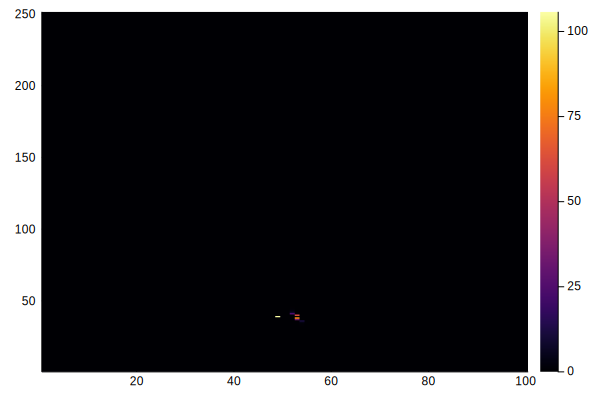

In [73]:
lift(m)
@time Lm = lift(m)
heatmap(abs.(Lm[:,200,:]))

We also need the projection procedure.

In [34]:
function project(Φ::Lift)
    f = sum(Φ[:,:,:], dims = 3) |> x->dropdims(x, dims = 3)
    STFT( f, freq(Φ), time(Φ), width(Φ) )
end

project (generic function with 1 method)

8.38177514377851e-20

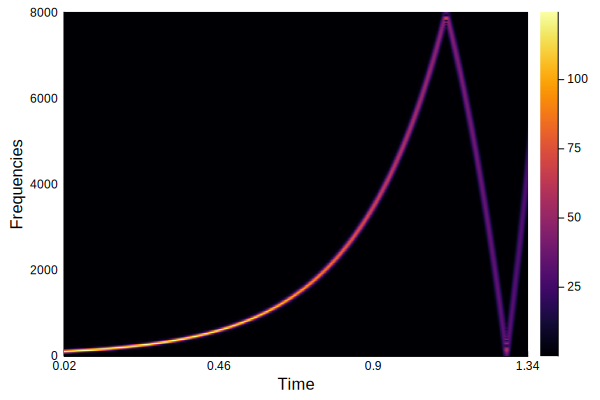

In [35]:
maximum(abs.(project(Lm)[:,:] - m[:,:])) |> display
show(project(Lm))

# Wilson-Cowan evolution

First of all, we need to define the kernel for the Kolmogorv equation.

Since the `threshold` function in the old version was wrong, here we are passing the size of each kernel as a parameter. It could surely be improved.

In [41]:
using OffsetArrays
# import ImageFiltering.centered

const Kernel = Array{OffsetArrays.OffsetArray{Float64,2,Array{Float64,2}},2}

# Kolmogorov kernel
K(t,p,q; ν = 1.) = sqrt(3)*exp(-4*(3*(p[1]-q[1])^2-3*(p[1]-q[1])*(p[2]+q[2])*t+t^2*(p[2]^2+p[2]*q[2]+q[2]^2))/t^3/ν^2)/π/t^2/ν^2

# Precomputation of the kernel
function kernel_computation(freq::Union{Frequencies, FloatRange{Float64}}, slopes::FloatRange{Float64}, τ;  n::Int = 20, args...)
    [centered([K(τ, (freq[k],slopes[l]), (freq[k] + i*step(freq),slopes[l] + j*step(slopes)); args...) for i in -n:n, j in -n:n]) 
            for k in 1:length(freq), l in 1:length(slopes)]
end

# Given a precomputed kernel K and a signal a, compute the required integral
function apply_kernel(a, K::Kernel)
    @assert size(K) == size(a)
    b = similar(a)
    for k in 1:size(K,1), l in 1:size(K,2)
        el = 0
        KK = K[k,l]
        for i in axes(KK,1), j in axes(KK,2)
            el += a[ clamp(k+i, 1, size(a,1)), clamp(l+j, 1, size(a,2))]*KK[i,j]
        end
        b[k,l] = el
    end
    b
end

apply_kernel (generic function with 1 method)

  5.297304 seconds (168.82 M allocations: 4.092 GiB, 45.91% gc time)


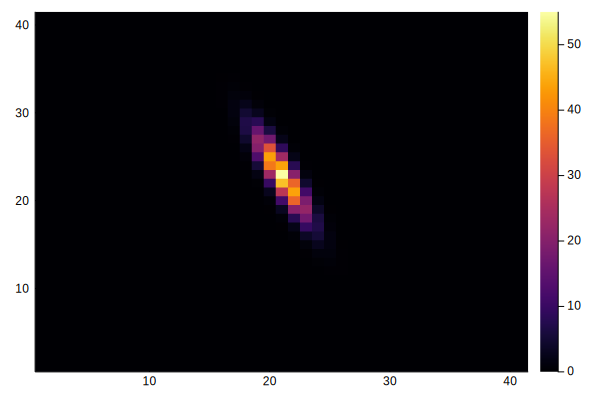

In [68]:
kernel_computation(normalize(freq(Lm)), time(Lm), .1)
@time k = kernel_computation(normalize(freq(Lm)), slopes(Lm), .1)
heatmap(k[100,50])

Then, we define the sigmoid function.

In [40]:
arg(z) = atan(imag(z), real(z))
σ(z) = exp(im*arg(z))*min(1, max(abs(z), -1))

σ (generic function with 1 method)

Finally, we can proceed with the WC evolution.

In [117]:
function wc_delay(input::Lift, α, β, γ; 
        K::Union{Nothing, Kernel} = nothing, τdx = 20, 
        normalize_freq::Bool = true, normalize_sigmoid::Bool = true,
        args...)
    x = time(input)
    y = normalize_freq ? normalize(freq(input)) : freq(input)
    z = slopes(input)
    
    # adapted sigmoid
    M = normalize_sigmoid ? maximum(abs.(input[:,:,:])) : 1
    σ(z) = exp(im*arg(z))*min(M, max(abs(z), -M))
    
    τ=τdx*step(x)
    if K == nothing 
        K = kernel_computation( y, z, τ; args...)
    end
    
    iteration(Φt, Φt_τ, h) =  (1-α*step(x))*Φt + γ*step(x)*step(y)*step(z)*apply_kernel(σ.(Φt_τ),K) + β*step(x)*h

    out = Array{Complex{Float64}, 3}(undef, length(y), length(x), length(z))
    out[:,1,:] = copy(input[:, 1,:])
    mat_zero = zeros(Complex{Float64},size(out[:,1,:])...)
    for t in 1:τdx
         out[:, t+1,:] = iteration(out[:,t,:],mat_zero, input[:,t,:])
    end
    for t in τdx+1:(length(x)-1)
         out[:,t+1,:] = iteration(out[:,t,:],out[:,t-τdx,:], input[:,t,:])
    end
    Lift(out, freq(input), x, z, width(input))
end

wc_delay (generic function with 1 method)

  1.236610 seconds (44.33 M allocations: 1.077 GiB, 42.89% gc time)


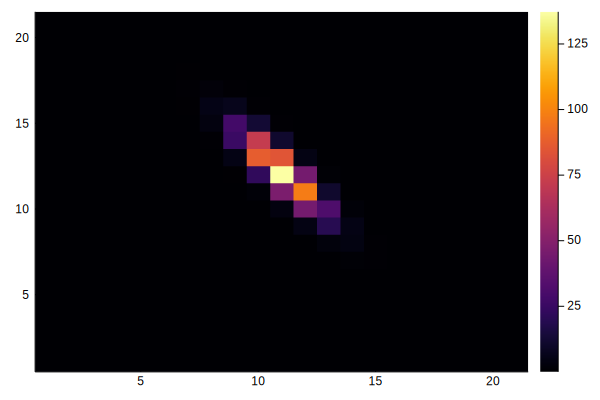

In [118]:
τ = 20 * step(time(Lm))
@time k = kernel_computation(normalize(freq(Lm)), slopes(Lm), τ, n = 10)
heatmap(k[100,50])

 27.180703 seconds (8.91 k allocations: 1.584 GiB, 1.42% gc time)


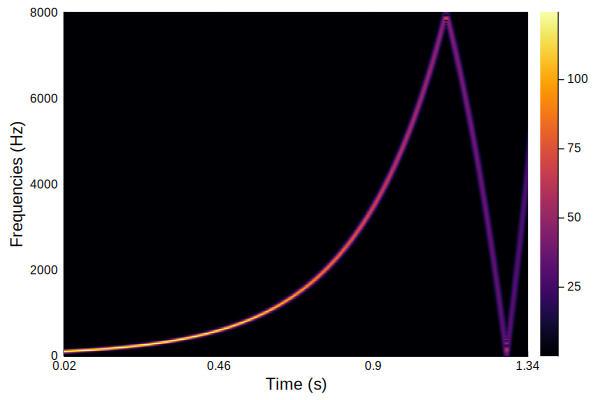

In [75]:
wc_delay(Lm, 0, 0, 0, K=k)
@time W = wc_delay(Lm, 10, 10, 10, K=k)
show(project(W))

# Test on interrupted sound

  0.001784 seconds (82 allocations: 1.648 MiB)


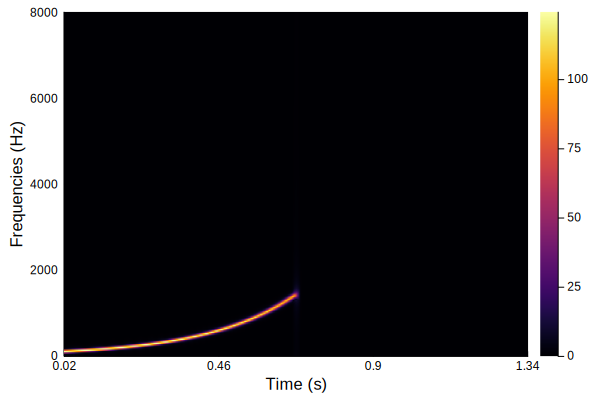

In [119]:
y = [ t <= size(s, 1) ? sin(exp((t+20000)/4000)) : 0. for t in 1:2*size(s,1) ]
wavwrite(y, "ugo-corr.wav", Fs = rate)

@time m2 = stft(y, 500, 450, fs = rate, window = hanning)
show(m2) 

  0.459760 seconds (1.11 M allocations: 434.166 MiB, 44.73% gc time)
 25.759459 seconds (8.92 k allocations: 1.823 GiB, 1.43% gc time)


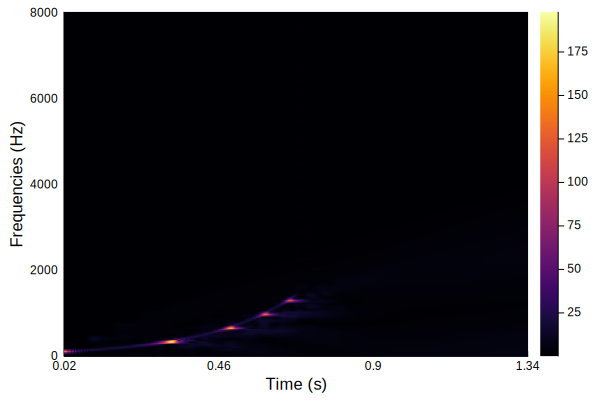

In [122]:
@time Lm2 = lift(m2)
@time W = wc_delay(Lm2, 40, 100, 100, K=k)
show(project(W))

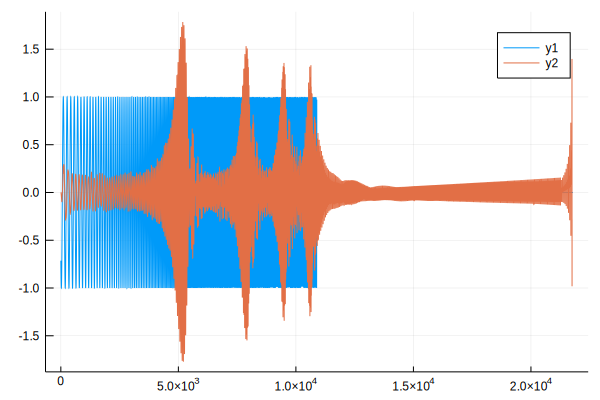

In [123]:
res = istft(project(W))
plot([y,res]) |> display
wavwrite(res, "ugo-corr-res.wav", Fs = rate)

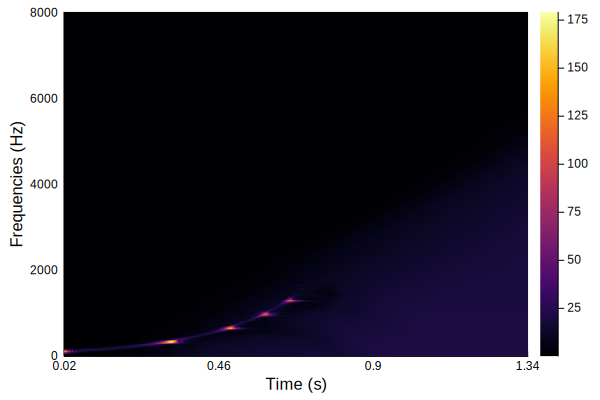

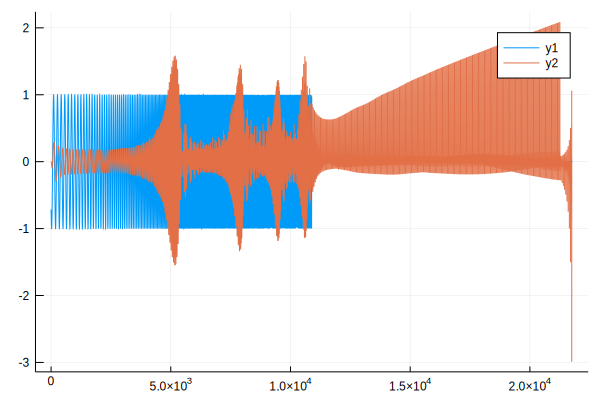

 25.986913 seconds (8.91 k allocations: 1.584 GiB, 1.41% gc time)


In [111]:
@time W = wc_delay(Lm2, 50, 100, 250, K=k)
show(project(W)) |> display
res = istft(project(W))
plot([y,res]) |> display
wavwrite(res, "ugo-corr-res2.wav", Fs = rate)